In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier
from lightgbm import LGBMRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import LocalOutlierFactor
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold
from optuna.samplers import TPESampler
import optuna
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.feature_selection import RFE
from sklearn.inspection import permutation_importance

c:\Users\Pc\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# Dosya okuma
df = pd.read_csv(r'C:\Users\Pc\Desktop\enerjisa_train_imputed.csv')

df_2 = df.copy()

# Time serilerini çıkarıcaz en son onları bakıcaz. Belki ayrı değerlendirip sonucun ortalamasını alıcaz
df.drop(columns=(['Timestamp','month','year','week','hour']),inplace=True)

# DATA EXPLORATION

In [3]:
def data_discovery(df):
  df.info()
  print('------------------------')
  print('Number of rows: ', df.shape[0])
  print('Number of columns: ', df.shape[1])
  print('------------------------')
  print(df.head(10))
  print('------------------------')
  print(df.tail(10))
  missing_values = df.isnull().sum()
  if missing_values.sum() == 0:
    print('There are no missing values in the dataset')
  else:
    print(missing_values)
  print('------------------------')
  print(df.describe())

In [4]:
def explore_data_types(df):
  print('Basic information about the data set:')
  print(df.info())
  numeric_columns = df.select_dtypes(include=['int64','float64']).columns
  print("\nNumeric Columns:")
  print(numeric_columns)
  categorical_columns = df.select_dtypes(include=['object']).columns
  print("\nCategorical Columns:")
  print(categorical_columns)
  cardinal_columns = [column for column in df.columns if df[column].nunique() == len(df)]
  print('\nCardinal Columns:')
  print(cardinal_columns)
  binary_columns = [column for column in df.columns if df[column].nunique() == 2]
  print('\nBinary Columns')
  print(binary_columns)

In [5]:
data_discovery(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136730 entries, 0 to 136729
Data columns (total 77 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   Gearbox_T1_High_Speed_Shaft_Temperature            136730 non-null  float64
 1   Gearbox_T3_High_Speed_Shaft_Temperature            136730 non-null  float64
 2   Gearbox_T1_Intermediate_Speed_Shaft_Temperature    136730 non-null  float64
 3   Temperature Gearbox Bearing Hollow Shaft           136730 non-null  float64
 4   Tower Acceleration Normal                          136730 non-null  float64
 5   Gearbox_Oil-2_Temperature                          136730 non-null  float64
 6   Tower Acceleration Lateral                         136730 non-null  float64
 7   Temperature Bearing_A                              136730 non-null  float64
 8   Temperature Trafo-3                                136730 non-null  float6

# DATA VISUALIZATION

In [7]:
def numeric_columns_visualization(df):
  numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
  n_rows = int(np.ceil(len(numeric_columns) / 3))  # Satır sayısını hesaplama

  fig, ax = plt.subplots(nrows=n_rows, ncols=3, figsize=(18, 6 * n_rows))  # Şekil oluşturma
  ax = ax.flatten()  # ax'i bir dizi olarak düzleştiriyoruz

  for i, column in enumerate(numeric_columns):  # enumerate ile i'yi tanımlama
      sns.histplot(df[column], kde=True, bins=50, ax=ax[i])
      ax[i].set_title(f'Histogram of {column}')
      ax[i].set_xlabel(column)
      ax[i].set_ylabel('Count')

  plt.tight_layout()  # Grafiklerin üst üste binmemesi için
  plt.show()

c:\Users\Pc\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Pc\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Pc\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Pc\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

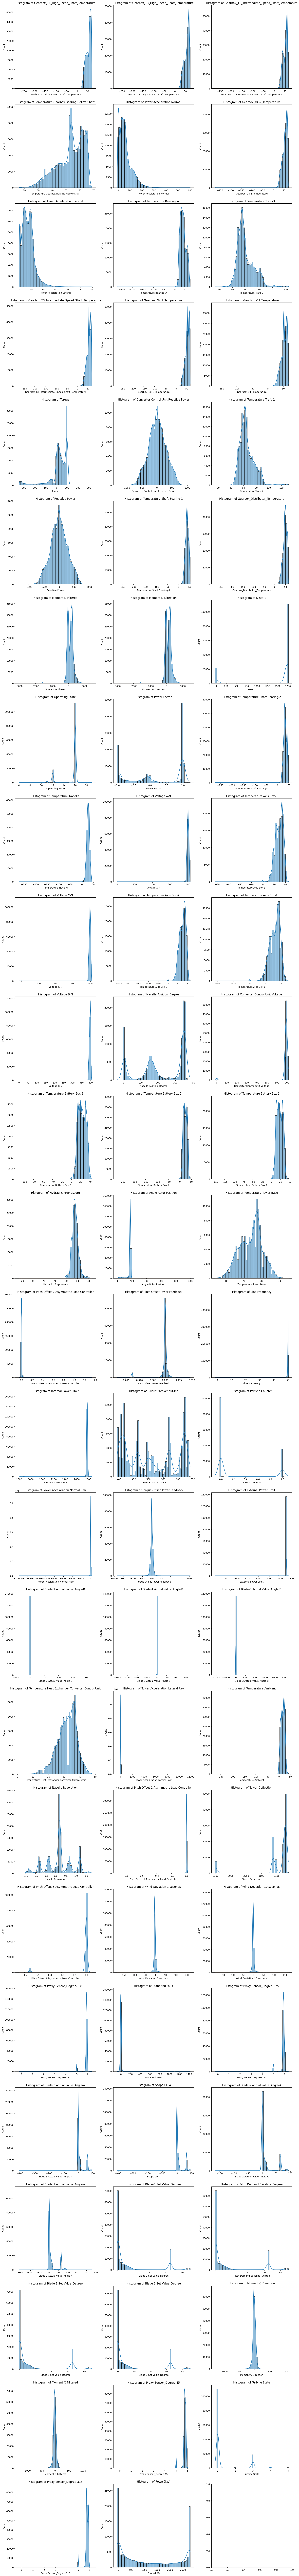

In [8]:
numeric_columns_visualization(df)

# MISSING VALUES

In [9]:
def handle_missing_values(df):
  missing_values = df.isnull().sum()
  if missing_values.sum() == 0:
    print('There is no missing values')
  else:
    df.dropna(inplace=True)
    print('Missing values deleted')

In [10]:
handle_missing_values(df)

There is no missing values


# OUTLIERS

In [3]:
def outliers_detection(df):
    lof = LocalOutlierFactor(n_neighbors=100)
    lof_scores = lof.fit_predict(df)
    # Karşılıklı bilgi skoru ve eşik değeri hesaplama
    lof_scores = lof.negative_outlier_factor_
    threshold = np.percentile(lof_scores, 95)

    # Skorları ve aykırı değerleri ekleme                 
    df['Lof_score'] = lof_scores
    df['Outlier'] = df['Lof_score'].apply(lambda x: 0 if x <= threshold else 1)       # büyük eşit muhabbeti önemli çünkü eşik değerde olan çok veri varmış      

    # Aykırı değerleri filtreleme ve geri döndürme
    filtered_df = df[df['Outlier'] == 0].copy()          # copy olayı sıkıntı df = df olmuyor 
    outlier_df = df[df['Outlier'] == 1].copy()            
    # Geçici sütunları kaldırma
    filtered_df.drop(columns=['Lof_score', 'Outlier'], inplace=True)

    print('Orijinal df şekli:', df.shape)
    print('Filtrelenmiş df şekli:', filtered_df.shape)

    return filtered_df, outlier_df.index

# Burada outlier çıkarmak yerine çünkü time series olduğu için devamlılığı bozuyor. Outlier tespit edip KNN ile outlier değerleri None yapıp sonra interpolate yapılabilir ?

In [4]:
df, outlier_index = outliers_detection(df)

Orijinal df şekli: (136730, 79)
Filtrelenmiş df şekli: (129893, 77)


# FEATURE SELECTION I ( Mutual Informatıon)

In [43]:
def mi_selection(df):
  X = df.drop(columns=['Power(kW)'])
  y = df['Power(kW)']

  # Karşılıklı bilgi skorlarını hesaplama
  mi_scores = mutual_info_regression(X, y, random_state=42)

  # Skorları DataFrame'e dönüştürme ve sıralama
  mi_df = pd.DataFrame(mi_scores, index=X.columns, columns=['MI Scores'])
  mi_df = mi_df.sort_values(by='MI Scores', ascending=False)

  # Önemli özelliklerin seçilmesi
  # Örneğin en yüksek 10 özelliği seçiyoruz
  threshold = 0.1
  mi_df = mi_df[mi_df['MI Scores']>0.1]

  # Orijinal veri çerçevesinde sadece bu önemli özellikleri içeren bir veri çerçevesi oluşturma
  df_selected = df[mi_df.index.tolist() + ['Power(kW)']]
  return df_selected

In [44]:
df = mi_selection(df)

# HYPERPARAMETER OPTIMIZATION

In [ ]:
def objective(trial, X, y):
    param = {
        'objective': 'regression',
        'metric': 'rmse',
        'num_leaves': trial.suggest_int('num_leaves', 20, 200),              
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'lambda_l1': trial.suggest_float('lambda_l1', 0, 100),
        'lambda_l2': trial.suggest_float('lambda_l2', 0, 100),
        'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0, 15),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.2, 0.95),
        'bagging_freq': 1,
        'feature_fraction': trial.suggest_float('feature_fraction', 0.2, 0.95),
        'importance_type': trial.suggest_categorical('importance_type', ['split', 'gain']),
        'early_stopping_rounds': 10,
        'verbose': 0
    }

    cv = KFold(n_splits=5, shuffle=True, random_state=33)   # StratifiedKFold classification problemler için
    cv_scores = []

    for train_idx, test_idx in cv.split(X):                            # BURADA X, y VERMEK YERİNE X_TRAIN DİYE AYIRIP SONRASINDA YAPMAK LAZIM OLABİLİR
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model = lgb.LGBMRegressor(**param)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric='rmse',
        )

        y_pred = model.predict(X_test)
        score = np.sqrt(mean_squared_error(y_test, y_pred))
        cv_scores.append(score)

    return np.mean(cv_scores)


# Optuna çalıştırma
study = optuna.create_study(direction='minimize', sampler=TPESampler())
study.optimize(lambda trial: objective(trial, X, y), n_trials=100)

# En iyi hiperparametreleri ve sonuçları yazdırma
print('Best parameters:', study.best_params)
print('Best score:', study.best_value)

In [ ]:
study.best_params

In [ ]:
study.best_value   # Ortalama RMSE: 20.622234016012136 X_train, X_test olarak datayı bölüp cross-validation yapınca olan değer. 19.28 X,y olarak bölüp cv yapınca olan değer

# FEATURE SELECTION II ( PERMUTATION IMPORTANCE )

In [27]:
from sklearn.inspection import permutation_importance

In [28]:
def permutation_importance(df):
    X = df.drop(columns=['Power(kW)'])
    y = df['Power(kW)']

    # Eğitim ve test verilerini ayırma
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)         # BEN FARKLI FARKLI X_TRAIN KULLANABİLİR MİYİM YOKSA RANDOM_STATE = 42 DEYİNCE HEP AYNI X_TRAIN DIYE MI AYIRCAK

    params = {'num_leaves': 21,                                                                         # KONTROL EDERİZ ASLINDA FARKLI YERLERDE AYIRIP VERİLERİNE BAKIP İÇİNDEN
    'max_depth': 11,
    'learning_rate': 0.06858621113272588,
    'n_estimators': 1808,
    'min_child_samples': 12,
    'lambda_l1': 61.59322472192006,
    'lambda_l2': 26.154331646998816,
    'min_gain_to_split': 0.7162785938575005,
    'bagging_fraction': 0.923107804451387,
    'feature_fraction': 0.7301909861239382,
    'importance_type': 'gain'}

    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train)

    # Permutasyon önemini hesaplayın
    perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42 )    # BU FONKSİYON DIŞINDA ÇALIŞIYOR AMA İÇİNDEYKEN ÇALIŞMIYOR

    # Önem sıralamasına göre özellikleri sıralayın
    sorted_idx = perm_importance.importances_mean.argsort()

    # Önemli olmayan özellikleri belirleyin ve çıkarın
    threshold = 0.00001  # Önemli olmayan özellikleri belirlemek için bir eşik değeri belirleyin
    low_importance_features = X.columns[sorted_idx][perm_importance.importances_mean[sorted_idx] < threshold]
    X_train_reduced = X_train.drop(columns=low_importance_features)
    X_test_reduced = X_test.drop(columns=low_importance_features)

    # CV test etme
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse_scores = []

    # Her fold için eğitim ve test işlemi
    for train_index, test_index in kf.split(X_train_reduced):
        X_fold_train, X_fold_test = X_train_reduced.iloc[train_index], X_train_reduced.iloc[test_index]
        y_fold_train, y_fold_test = y_train.iloc[train_index], y_train.iloc[test_index]
        
        # LightGBM modelini eğitin
        model_reduced = lgb.LGBMRegressor(**params)
        model_reduced.fit(X_fold_train, y_fold_train)
        
        # Tahminleri yapın
        y_pred_fold = model_reduced.predict(X_fold_test)
        
        # RMSE'yi hesaplayın
        rmse_fold = np.sqrt(mean_squared_error(y_fold_test, y_pred_fold))
        rmse_scores.append(rmse_fold)

    # KFold RMSE skorlarının ortalamasını alın
    mean_rmse = np.mean(rmse_scores)
    print(f"Ortalama RMSE: {mean_rmse}") # Ortalama RMSE: 20.114864006827663



In [ ]:
permutation_importance(df)    # BURASI ÇALIŞMIYOR ÖNCEDEN ÇALIŞTIRMIŞTIM

In [45]:
Reduced_columns = ['Torque', 'Pitch Demand Baseline_Degree',
       'Blade-1 Actual Value_Angle-A', 'Scope CH 4',
       'Blade-1 Set Value_Degree', 'Blade-2 Actual Value_Angle-A',
       'Blade-2 Set Value_Degree', 'Blade-3 Set Value_Degree',
       'Gearbox_T3_High_Speed_Shaft_Temperature',
       'Gearbox_T1_High_Speed_Shaft_Temperature', 'Gearbox_Oil-2_Temperature',
       'Power Factor', 'Tower Acceleration Normal',
       'Gearbox_T1_Intermediate_Speed_Shaft_Temperature',
       'Tower Acceleration Lateral',
       'Temperature Gearbox Bearing Hollow Shaft',
       'Gearbox_T3_Intermediate_Speed_Shaft_Temperature',
       'Gearbox_Oil-1_Temperature', 'Gearbox_Oil_Temperature',
       'Proxy Sensor_Degree-315', 'Voltage A-N',
       'Converter Control Unit Voltage', 'Voltage C-N', 'Moment D Filtered',
       'Moment D Direction', 'Pitch Offset Tower Feedback',
       'Proxy Sensor_Degree-45', 'Pitch Offset-2 Asymmetric Load Controller',
       'Temperature Bearing_A', 'Gearbox_Distributor_Temperature',
       'Converter Control Unit Reactive Power', 'Reactive Power',
       'Voltage B-N', 'Pitch Offset-1 Asymmetric Load Controller',
       'Temperature Trafo-3', 'Turbine State', 'Operating State',
       'State and Fault', 'N-set 1', 'Temperature Trafo-2',
       'Circuit Breaker cut-ins', 'Temperature Shaft Bearing-1',
       'Proxy Sensor_Degree-135', 'Temperature Axis Box-1',
       'Temperature Axis Box-3', 'Temperature Axis Box-2']

In [46]:
X = X[Reduced_columns]

# FEATURE SELECTION III (RFE)

In [ ]:
from sklearn.feature_selection import RFE

In [ ]:
# Model ve RFE tanımlama
model = lgb.LGBMRegressor(**params)
rfe = RFE(model, n_features_to_select=35)  # Özellik sayısını belirleyin

# KFold ile çapraz doğrulama
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scores = []
best_rmse = np.inf
no_improvement_count = 0
max_no_improvement = 3  # RMSE iyileşmemesi sayısı

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

for train_index, test_index in kf.split(X_train):
    X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    
    # Özellik seçimi
    rfe.fit(X_train_fold, y_train_fold)
    selected_features = X_train_fold.columns[rfe.support_]
    
    # Seçilen özelliklerle model eğitimi
    model_reduced = lgb.LGBMRegressor(**params)
    model_reduced.fit(X_train_fold[selected_features], y_train_fold)
    
    # Tahmin ve performans değerlendirme
    y_pred_fold = model_reduced.predict(X_test_fold[selected_features])
    rmse_fold = np.sqrt(mean_squared_error(y_test_fold, y_pred_fold))
    
    rmse_scores.append(rmse_fold)
    
    # RMSE iyileşmesini kontrol etme
    if rmse_fold < best_rmse:
        best_rmse = rmse_fold
        no_improvement_count = 0
    else:
        no_improvement_count += 1
    
    # Erken durdurma kontrolü
    if no_improvement_count >= max_no_improvement:
        print(f"Early stopping triggered after {no_improvement_count} iterations without improvement.")
        break

# Ortalama RMSE hesaplama
mean_rmse = np.mean(rmse_scores)
print(f"Ortalama RMSE: {mean_rmse}")                     # Ortalama RMSE: 1090.7200510780185 verdi anlamadım ?

# MODEL PREDICTION

In [51]:
# LightGBM regresyon modeli oluşturma
model = lgb.LGBMRegressor(**params)

# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modeli eğitme
model.fit(X_train, y_train)

# Test seti üzerinde tahmin yapma
y_pred = model.predict(X_test)

# RMSE hesaplama
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse}')        # RMSE: 14.907601365784325      # BİDA YAPTIM 16.190435838372633 OLDU ACABA NE DEĞİŞTİ (X_train 46 kolonlu degil permutation olmamış hali bu yani)

[LightGBM] [Warning] feature_fraction is set=0.7301909861239382, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7301909861239382
[LightGBM] [Warning] min_gain_to_split is set=0.7162785938575005, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7162785938575005
[LightGBM] [Warning] lambda_l1 is set=61.59322472192006, reg_alpha=0.0 will be ignored. Current value: lambda_l1=61.59322472192006
[LightGBM] [Warning] lambda_l2 is set=26.154331646998816, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.154331646998816
[LightGBM] [Warning] bagging_fraction is set=0.923107804451387, subsample=1.0 will be ignored. Current value: bagging_fraction=0.923107804451387
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.7301909861239382, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7301909861239382
[LightGBM] [Warning] min_gain_to_split is set=0.

# TIMESERIES ( ARIMA / SARIMA )

In [3]:
!pip install pmdarima
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.feature_selection import RFE
from sklearn.inspection import permutation_importance
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tools.eval_measures import mse, rmse
from statsmodels.tsa.seasonal import seasonal_decompose

# VERİ TİPİ DÖNÜŞTÜRME

In [81]:
# Dosya okuma
dft = pd.read_csv(r'C:\Users\Pc\Desktop\enerjisa_train_imputed.csv')

# Eksik veri temizleme
dft = dft.dropna()

# Timestamp'ı indexe atama
dft['Timestamp']=pd.to_datetime(dft['Timestamp'])
dft.set_index('Timestamp',inplace=True)                  # time stamp yapıp indexe atıp freq ayalarmak veriyi daha doğru okuması için galiba yapılması gereken bir şey 

# Freq None to '10T', 10 dakikalık zaman aralıkları için 10T, Model ve resampling rolling gibi şeyler için önemli
# dft = dft.asfreq('10T')      Bu kısım eksik veri oluşturuyor nedense anlamadım

# FEATURE CREATION

In [82]:
# Timestamp'ten yeni feature'lar üretme
dft['day'] = dft.index.day
dft['day_of_week'] = dft.index.dayofweek
dft['day_of_year'] = dft.index.dayofyear
dft['quarter'] = dft.index.quarter

In [203]:
# Target'a weekend ve night verilerinin etki edeceğini düşündüğüm için yeni feature'lar ürettim
dft['weekend'] = dft['day_of_week'].apply(lambda x : 0 if x <= 5 else 1)
dft['night'] = dft['hour'].apply(lambda x : 1 if ((x >= 0 ) & ( x <= 6)) else 0)

In [204]:
# İstediğimiz veri setini alıyoruz
dft = dft[['year','month','week','day','hour','day_of_week','day_of_year','quarter','weekend','night','Power(kW)']]

# DATA VISUALIZATION

C:\Users\Pc\AppData\Local\Temp\ipykernel_3580\3497025858.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dft_hourly = dft['Power(kW)'].resample(rule='H').mean()


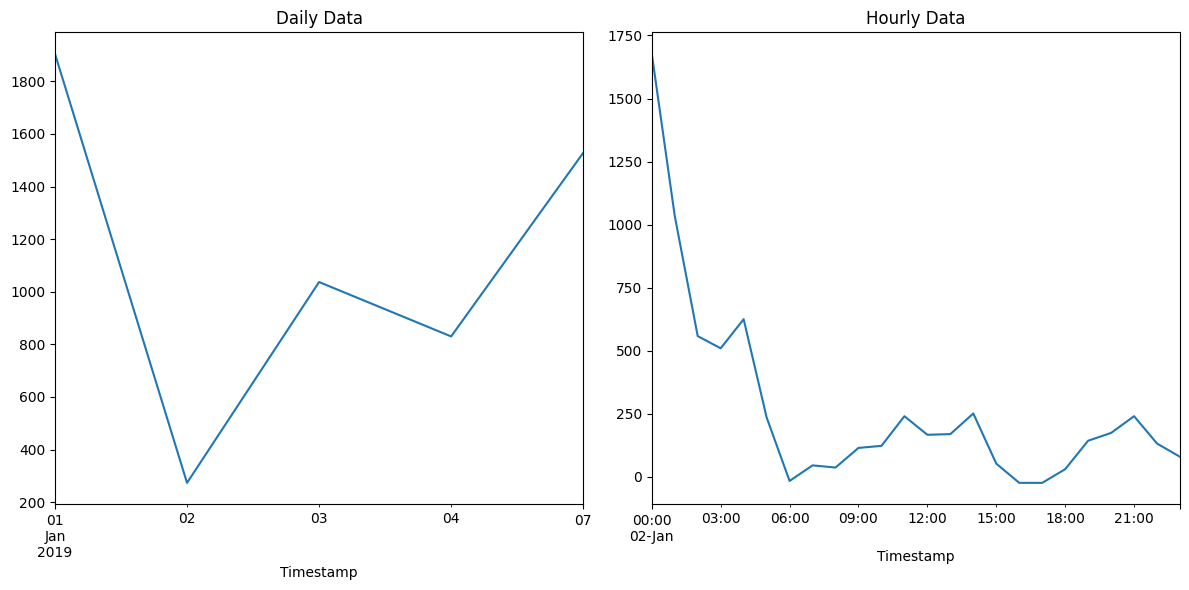

In [310]:
dft_daily = dft['Power(kW)'].resample(rule='B').mean()
dft_hourly = dft['Power(kW)'].resample(rule='H').mean()
# Grafik oluşturma
fig, ax = plt.subplots(1, 2, figsize=(12, 6))  # `plt.subplots` fonksiyonunu kullanın

# Grafik çizdirme
dft_daily.head(5).plot(x='date', y='Power(kW)', ax=ax[0], title='Daily Data')
dft_hourly.iloc[24:48].plot(x='date', y='Power(kW)', ax=ax[1], title='Hourly Data')

plt.tight_layout()  # Grafiklerin düzenini iyileştirmek için
plt.show()

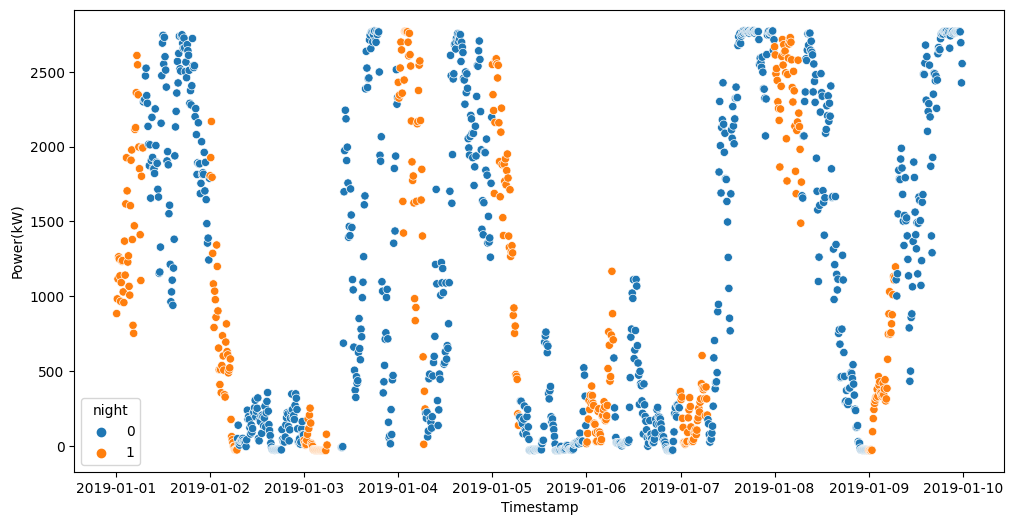

In [299]:
filtered_data = dft['Power(kW)'].loc[(dft.index > '2019-01-01') & (dft.index < '2019-01-10')]
plt.figure(figsize=(12, 6))
sns.scatterplot(data=filtered_data, x=filtered_data.index, y= dft['Power(kW)'].loc[filtered_data.index], hue=dft['night'].loc[filtered_data.index])
plt.show() 

# TRAIN - TEST SPLIT

In [205]:
# Veri setini sıralı olacak şekilde ve %80 X_train, %20 X_test olacak şekilde ayırdım
X_train = dft.iloc[:109384]
X_test = dft.iloc[109384:136730]

# SEASONAL DECOMPOSE

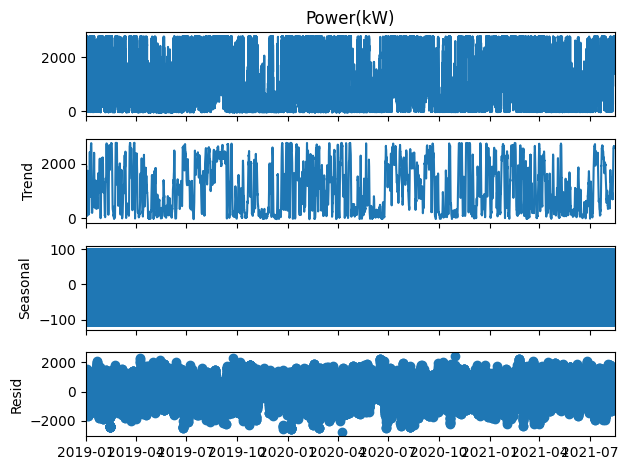

In [91]:
# fonksiyonu çalıştırıyoruz. additive olması zamanın etkisinin olmaması , period 1 gün de 24 saat 1 saat de 6 tane 10'ar dakika olması
result = seasonal_decompose(dft['Power(kW)'], model='additive', period = 144 )  # period should be set based on your data

result.plot();    # Seasonal bir data değil anlaşılan

# ADF TEST ( STATIONARY CHECK )

In [94]:
def adf_test(target):
    result = adfuller(target)
    return result[1]  # p-değeri döndür

def make_stationary(target):
    d = 0
    p_value = adf_test(target)
    while p_value >= 0.05:     # p-değeri 0.05'ten büyükse bu işlem devam edecek
        d += 1                 # her devam ettiğinde d'yi 1 artıracak
        target = target.diff().dropna()
        p_value = adf_test(target)
        print(f'd={d}, p-değeri={p_value}')
    return d

d = make_stationary(dft['Power(kW)'])
print(f'Final d değeri: {d}') 

Final d değeri: 0


# AUTO_ARIMA ( p, d, q )

In [95]:
# fonksiyonu çalıştırıyoruz p ve q aralığı verip bir de seasonality var mı yok mu söylememiz gerekiyor
arima_deneme = auto_arima(X_train['Power(kW)'], start_p = 0, start_q = 0, max_p = 3, max_q = 3, seasonal = False, trace = True)

# özet inceleme
arima_deneme.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1464829.529, Time=1.47 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1464808.109, Time=1.72 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1464801.557, Time=3.50 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1464827.529, Time=0.70 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1463712.175, Time=26.83 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1462951.892, Time=18.50 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1463477.711, Time=6.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1462781.478, Time=34.91 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1463366.855, Time=9.91 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1462762.533, Time=41.04 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1462768.799, Time=21.16 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1462761.316, Time=27.86 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1462762.392, Time=47.91 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=1462759.314

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:               109368
Model:               SARIMAX(3, 1, 3)   Log Likelihood             -731372.657
Date:                Wed, 14 Aug 2024   AIC                        1462759.314
Time:                        19:05:00   BIC                        1462826.531
Sample:                             0   HQIC                       1462779.631
                             - 109368                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0315      0.130     -0.241      0.809      -0.287       0.224
ar.L2          0.3442      0.053      6.537      0.000       0.241       0.447
ar.L3          0.1687      0.030      5.692      0.000       0.111       0.227
ma.L1          0.0384      0.131      0.294      0.768      -0.218       0.294
ma.L2         -0.4628      0.052     -8.971      0.000      -0.564      -0.362
ma.L3         -0.2143      0.045     -4.791      0.000      -0.302      -0.127
sigma2       3.77e+04     49.108    767.736      0.000    3.76e+04    3.78e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           2709041.10
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.91   Skew:                            -0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                        27.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# ACF (p)

<Figure size 1000x600 with 0 Axes>

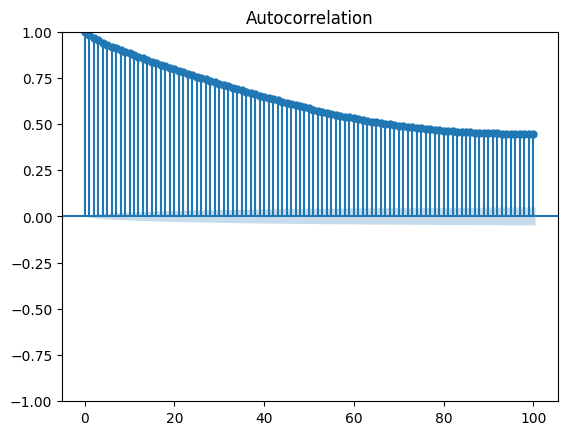

In [170]:
plt.figure(figsize=(10, 6))
plot_acf(dft['Power(kW)'], lags=100);

# PACF (q)

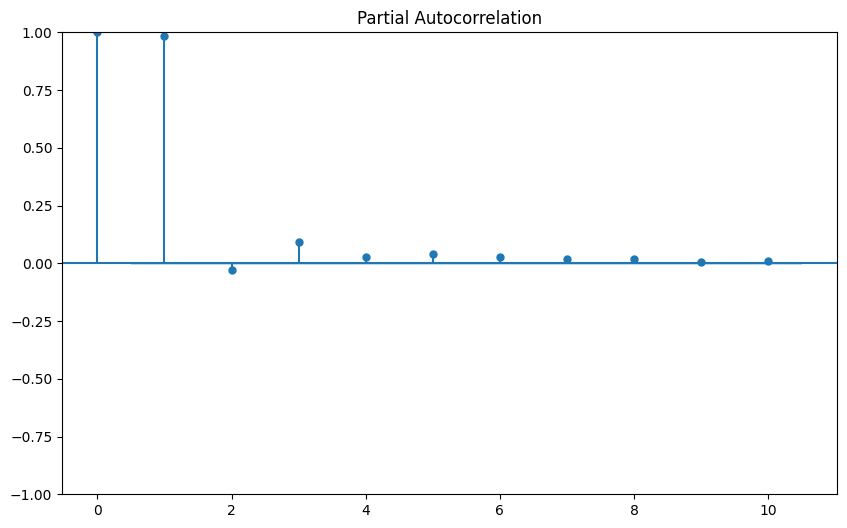

In [169]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_pacf(dft['Power(kW)'], lags=10, ax=ax, method='ywm');

# MODEL KURMA

In [270]:
model = sm.tsa.SARIMAX(endog = X_train['Power(kW)'],
                        order=(1,0,1),
                        seasonal_order=(0,0,0,0),
                        enforce_invertibility = False,
                        )
# exog = X_train.drop(columns=['Power(kW)']) sağlam rmse çıkarıyor 139853.21490428815
# exog olmadan 194 çıkıyor rmse

c:\Users\Pc\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Pc\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [271]:
result = model.fit()

c:\Users\Pc\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [272]:
y_train_pred = result.predict(start=pd.to_datetime('2019-01-01 00:00:00'),
                              end=pd.to_datetime('2021-02-05 09:30:00'),
                              freq='10T'
                              )

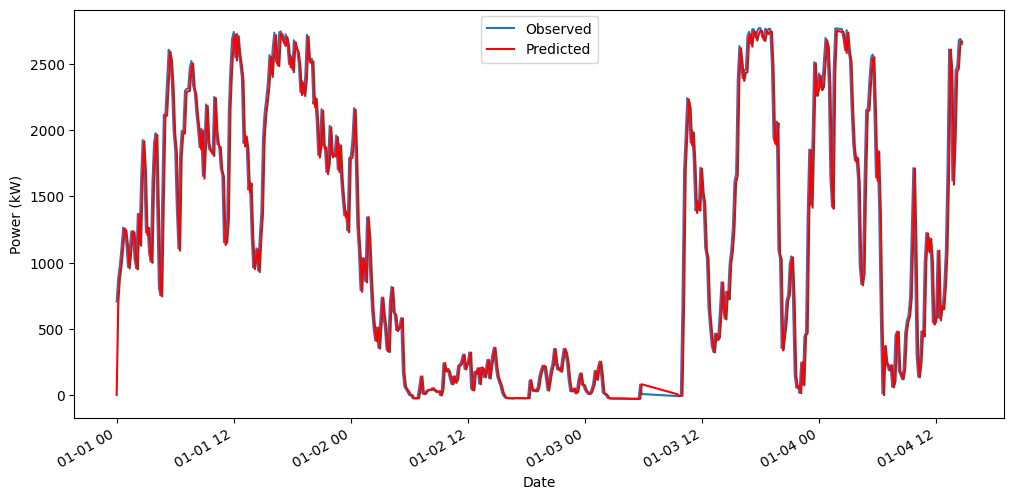

In [268]:
# Plot the original data
ax = X_train['Power(kW)'].head(500).plot(figsize=(12,6), label='Observed')

# Plot the predictions on the same axes
y_train_pred.head(500).plot(ax=ax, color='red', label='Predicted')

# Add labels and legend
ax.set_xlabel('Date')
ax.set_ylabel('Power (kW)')
plt.legend()
plt.show()

In [273]:
mse = mean_squared_error(X_train['Power(kW)'], y_train_pred)

# RMSE hesaplama
rmse = np.sqrt(mse)

rmse            # Train setle kurulmuş modelin kendi setini tahmini 194 saçma biraz

195.1563277084951

# PREDICTION

In [262]:
y_test_pred = result.predict(steps=10000, freq='10T' )

In [264]:
y_test_pred.shape

(109384,)

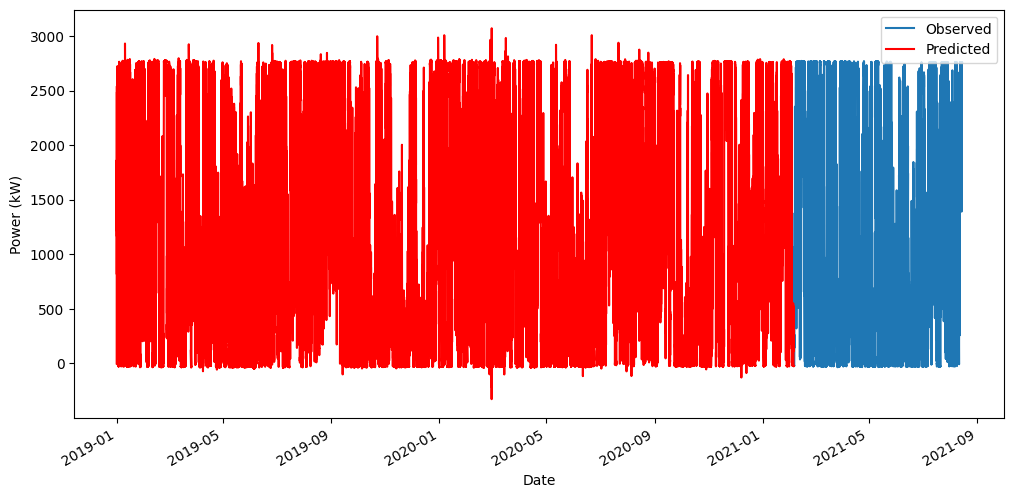

In [121]:
# Plot the original data
ax = X_test['Power(kW)'].plot(figsize=(12,6), label='Observed')

# Plot the predictions on the same axes
y_test_pred.plot(ax=ax, color='red', label='Predicted')

# Add labels and legend
ax.set_xlabel('Date')
ax.set_ylabel('Power (kW)')
plt.legend()
plt.show()

# RANDOMFOREST

In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

In [3]:
df3 = pd.read_csv(r'C:\Users\Pc\Desktop\enerjisa_train_imputed.csv')
df3['Timestamp']=pd.to_datetime(df3['Timestamp'])
df3.set_index('Timestamp',inplace=True)
df3['day'] = df3.index.day
df3['day_of_week'] = df3.index.dayofweek
df3['day_of_year'] = df3.index.dayofyear
df3['quarter'] = df3.index.quarter
df3['weekend'] = df3['day_of_week'].apply(lambda x : 0 if x <= 5 else 1)
df3['night'] = df3['hour'].apply(lambda x : 1 if ((x >= 0 ) & ( x <= 6)) else 0)


In [5]:
df3 = df3[['month','year', 'hour', 'week', 'day', 'day_of_week', 'day_of_year', 'quarter','weekend', 'night','Torque', 'Pitch Demand Baseline_Degree',
       'Blade-1 Actual Value_Angle-A', 'Scope CH 4',
       'Blade-1 Set Value_Degree', 'Blade-2 Actual Value_Angle-A',
       'Blade-2 Set Value_Degree', 'Blade-3 Set Value_Degree',
       'Gearbox_T3_High_Speed_Shaft_Temperature',
       'Gearbox_T1_High_Speed_Shaft_Temperature', 'Gearbox_Oil-2_Temperature',
       'Power Factor', 'Tower Acceleration Normal',
       'Gearbox_T1_Intermediate_Speed_Shaft_Temperature',
       'Tower Acceleration Lateral',
       'Temperature Gearbox Bearing Hollow Shaft',
       'Gearbox_T3_Intermediate_Speed_Shaft_Temperature',
       'Gearbox_Oil-1_Temperature', 'Gearbox_Oil_Temperature',
       'Proxy Sensor_Degree-315', 'Voltage A-N',
       'Converter Control Unit Voltage', 'Voltage C-N', 'Moment D Filtered',
       'Moment D Direction', 'Pitch Offset Tower Feedback',
       'Proxy Sensor_Degree-45', 'Pitch Offset-2 Asymmetric Load Controller',
       'Temperature Bearing_A', 'Gearbox_Distributor_Temperature',
       'Converter Control Unit Reactive Power', 'Reactive Power',
       'Voltage B-N', 'Pitch Offset-1 Asymmetric Load Controller',
       'Temperature Trafo-3', 'Turbine State', 'Operating State',
       'State and Fault', 'N-set 1', 'Temperature Trafo-2',
       'Circuit Breaker cut-ins', 'Temperature Shaft Bearing-1',
       'Proxy Sensor_Degree-135', 'Temperature Axis Box-1',
       'Temperature Axis Box-3', 'Temperature Axis Box-2','Power(kW)']]        # hour dayofweek filan bunların tipi ne olacak ?

In [30]:
X = df3.drop(columns ='Power(kW)')
y = df3['Power(kW)']

In [31]:
# Train/Test bölmesi
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [9]:
# KFold çapraz doğrulama
kf = KFold(n_splits=5, shuffle=False)

# Hiperparametre aralıkları
param_distributions = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Random Forest modeli
model = RandomForestRegressor(random_state=42)

# RandomizedSearchCV ile optimizasyon
random_search = RandomizedSearchCV(
    model, 
    param_distributions=param_distributions,
    n_iter=100,  # Aranacak kombinasyon sayısı
    cv=kf,  # KFold çapraz doğrulama
    scoring='neg_mean_squared_error',
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Optimizasyon işlemi (Sadece X_train ve y_train kullanılıyor)
random_search.fit(X_train, y_train)

# En iyi parametreler ve en iyi skor
best_params = random_search.best_params_
best_score = np.sqrt(-random_search.best_score_)

print(f'Best Parameters: {best_params}')
print(f'Best Cross-Validated RMSE: {best_score}')

Fitting 5 folds for each of 100 candidates, totalling 500 fits


c:\Users\Pc\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
145 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
117 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Pc\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Pc\anaconda3\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\Pc\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\Pc\anaconda3\Lib\site-packages\sklearn\util

Best Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}
Best Cross-Validated RMSE: 42.63361406516654


In [29]:
# En iyi parametrelerle model
best_model = RandomForestRegressor(**best_params, random_state=42)
best_model.fit(X_train, y_train)

# Test seti üzerinde tahmin yapma
y_pred = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))   # ağaç yapılarında standartlaştırma yok !

print(f'Test RMSE: {rmse}')   # random forest için outlier yapabilirim sadece sarima da devamlılık bozunca sıkıntı gibi ya da outlier bulup interpolasyonla filan doldursak mantıklı olabilir belki

Test RMSE: 40.2286052874282


In [11]:
best_params = {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}
# Test RMSE: 39.34809684624838
# Outlier_detection fonksiyonuyla outlier temizledim RMSE: 40.2286052874282 oldu anlamadım neden KNN le yapmıstık bide